# Exercise and Non-Exercise Predictors of Heart Disease

Heart disease (HD) has many symptoms; thus, its diagnosis is difficult. It is critical to minimize testing (Bösner et al., 2010), while “[identifying] serious cardiac disease reliably” (Bösner et al., 2010). Our question is: Can exercise-related parameters more accurately diagnose HD than non-exercise-related predictors? We will create one model employing non-exercise factors including age, resting electrocardiogram, and resting blood pressure, and another for exercise-related factors including ST depression, angina, and slope during exercise (Detrano, n.d.). We used the “Heart Disease Data Set” (Detrano, n.d.), specifically the processed.cleveland.data, including 14 variables, with the diagnosis denoted from 0-4 (Detrano, n.d.).

In [1]:
#Source for the code:

#Detrano, R. (n.d.). processed.cleveland.data [Data set]. UCI Machine Learning 
#Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [2]:
# Installation of the required libraries to conduct our data analysis. Setting of the seed to ensure our analysis is reproducible.
library(tidyverse)
library(repr)
library(RColorBrewer)
library(tidymodels)
install.packages("themis") # Install the themis package to obtain the step_upsample() function. 
library(themis)
options(repr.matrix.max.rows = 6)
set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Reading in the data from our online source (Detrano, n.d.) using a read_csv function. 
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<b>WRANGLING THE DATA:</b>

With the data loaded, it is wrangled, creating the desired datasets. We assign column names, making the data understandable, and select the variables for each dataset. We learned to use the case_when() function to mutate the result variable such that when it has values of 1, 2, 3, or 4, it is attributed 1 and when it has a value of 0 it remains as such (DataScience Made Simple, 2023). This allows us to make our result binary, as opposed to having the five classes in the original dataset (Detrano, n.d.), thus our result is limited to no HD (0) or HD (1). The original dataset source indicates that its use is most relevant to identifying whether HD is present, rather than classifying disease severity (Detrano, n.d.), thus, we made the result binary too. We also removed any observations with an NA result. 

In [4]:
# Set the dataset's column names to the variable descriptions found in (Detrano, n.d.).
colnames(cleveland_data) <- c("age", "sex", "cp", "resting_blood_pressure", "chol", "fbs", "resting_electrocardio", "thalach", "exercise_angina", "exercise_st", "exercise_slope", "ca", "thal", "result")

In [5]:
# Mutate the result column such that values of 0 are assigned 0 and indicate no HD and values of 1, 2, 3, and 4 are assigned 1, indicating HD is present. 
# Mutate the result column into a factor, so it can be used to color and fill the graphs, as well as used in classification. 
# Filtering to remove observations that have NA values in the result column.
cleveland_data <- cleveland_data |>
                  mutate(result = case_when(result == 1 & 2 & 3 & 4 ~ 1, result == 0 ~ 0)) |> # We learned to use the case_when() function using (DataScience Made Simple, 2023). 
                  mutate(result = as_factor(result)) |>
                  filter(!is.na(result)) 

# Wrangling the data by creating the desired datasets.
# First dataset: data for variables that are unrelated to exercise.
cleveland_data_resting <- select(cleveland_data, age, resting_blood_pressure, resting_electrocardio, result) 

# Second dataset: data for exercise-related variables. 
cleveland_data_exercise <- select(cleveland_data, exercise_angina, exercise_st, exercise_slope, result)

In [6]:
# We used summarize to calculate the mean value of each column with respect to the diagnostic class, indicating their general values.
# This also helps us by indicating we need to scale the data.
cleveland_data_resting_mean <- cleveland_data_resting |>
    group_by(result) |>
    summarize(across(age:resting_electrocardio, mean))
cleveland_data_resting_mean

result,age,resting_blood_pressure,resting_electrocardio
<fct>,<dbl>,<dbl>,<dbl>
0,52.58537,129.2500,0.8353659
1,55.38182,133.2545,1.1636364


<i><b>Table 1:</b> Non-exercise predictors' means</i>.

In [7]:
# Using summarize, we calculated the mean for the predictor variable values with respect to each diagnosis.
# This also helps us by letting us know that we need to scale the data.

cleveland_data_exercise_mean <- cleveland_data_exercise |>
    group_by(result) |>
    summarize(across(exercise_angina:exercise_slope, mean))
cleveland_data_exercise_mean

result,exercise_angina,exercise_st,exercise_slope
<fct>,<dbl>,<dbl>,<dbl>
0,0.1402439,0.5865854,1.408537
1,0.4545455,1.0054545,1.636364


<i><b>Table 2:</b> Exercise predictors' means</i>.

As an initial summary, we looked at each variable’s means (Tables 1 and 2) to understand the types of values that each holds with respect to each diagnosis. In Table 1, the means do not differ much between diagnoses for the non-exercise predictors. In Table 2, we observe the exercise predictors have different means between the diagnoses, except exercise_slope. From this, we predict that our exercise model will provide better classification accuracy than the non-exercise model, as the classes are more distinct. 

Our first dataset utilizes non-exercise parameters including age, as this contributes to HD diagnosis, with older ages being risk factors (Bösner et al., 2010). Blood sugar after fasting is included as its correlation to HD has been clinically identified (Shin et al., 2019). Finally, we used resting blood pressure as it constitutes “one of [HD's] most important risk factors” (Wu et al., 2015). 

Our second dataset includes exercise-related predictors. ST depression during exercise is used as it is critical for HD diagnosis, and identifying patient outcomes (Lanza et al., 2004). Angina during exercise is used as exercise stresses the heart, exposing this symptom (Harvard Health Publishing, 2021). Finally, the slope is used to study exercise testing's involvement in HD predictions, correlating to the illness' extent (Finkelhor et al., 1986). Both contain the result variable, indicating the categorical diagnosis (Detrano, n.d.).

<b>SPLITTING THE DATA INTO TRAINING AND TESTING:</b>

We will perform a $K$-nearest neighbors classification, thus, we split 75% of the data into training datasets, and the remaining 25% into testing datasets to utilize sufficient data for accurate models. 

In [8]:
# Splitting the datasets into training and testing data using 75% of the data in the training set.
set.seed(9999)

initial_split <- initial_split(cleveland_data_resting, prop = 0.75, strata = result)  
resting_train <- training(initial_split)   
resting_test <- testing(initial_split)

initial_split <- initial_split(cleveland_data_exercise, prop = 0.75, strata = result)  
exercise_train <- training(initial_split)   
exercise_test <- testing(initial_split)

<b>VISUALIZING THE DATA:</b>

Our preliminary visualizations are histograms of each predictor's distribution, coloured by diagnoses of 0 or 1. 

<b>NON-EXERCISE PREDICTORS GRAPHS:</b>

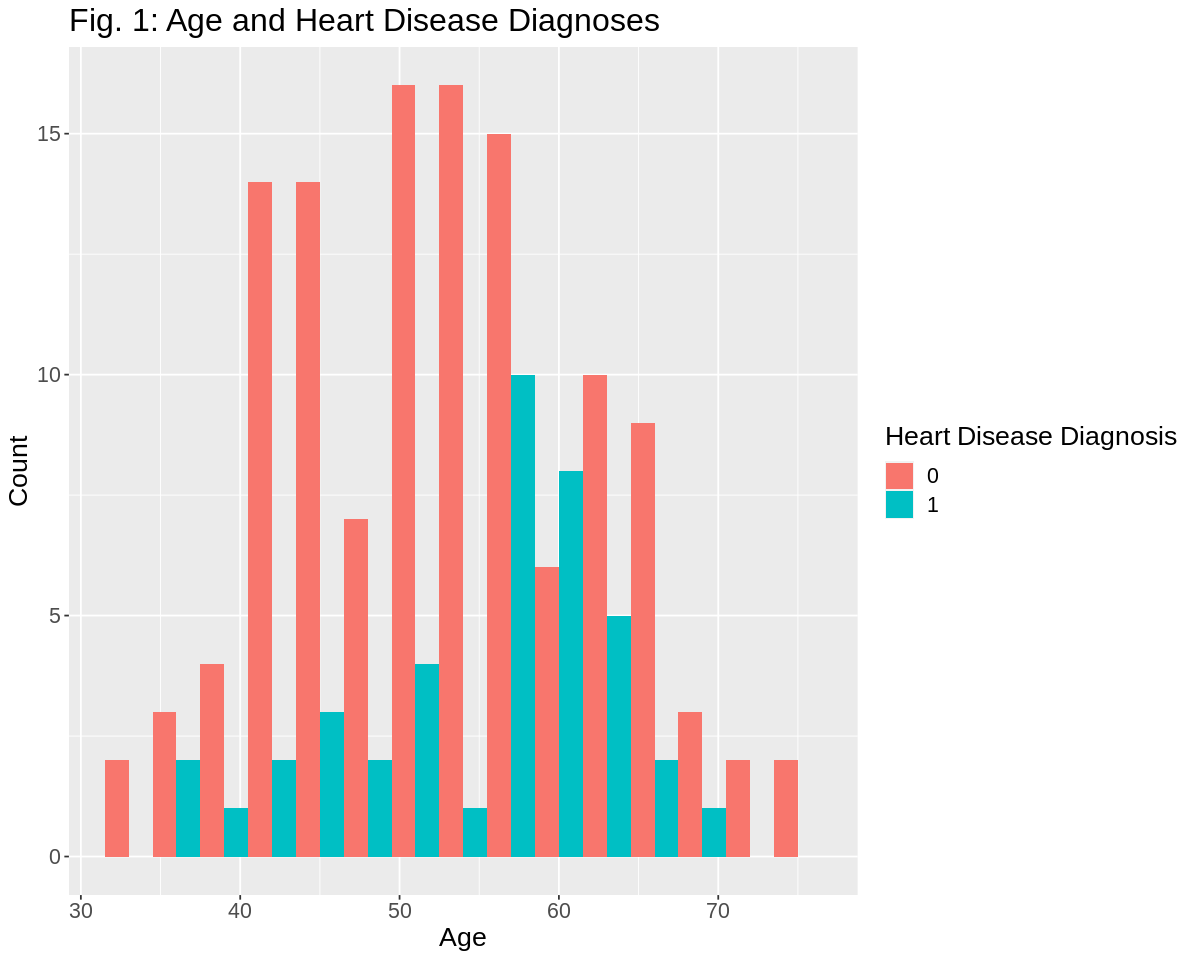

In [9]:
#Plotting the age variable in relation to the presence of HD. 
#All the titles in the plot and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

resting_age_plot <- ggplot(resting_train, aes(x = age)) +
    ggtitle("Fig. 1: Age and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result), position = "dodge", binwidth = 3) +
    xlab("Age") +
    ylab("Count") +
    labs(fill = "Heart Disease Diagnosis") +
    theme(text = element_text(size = 16))
resting_age_plot

<i><b>Figure 1:</b> Association between the age predictor values and HD diagnosis.</i>

Data for ages are concentrated between 50-65. At lower ages, around 40, there are more HD diagnoses than non-diagnoses, however, as age increases, we see that the number of diagnoses and non-diagnoses are closer.

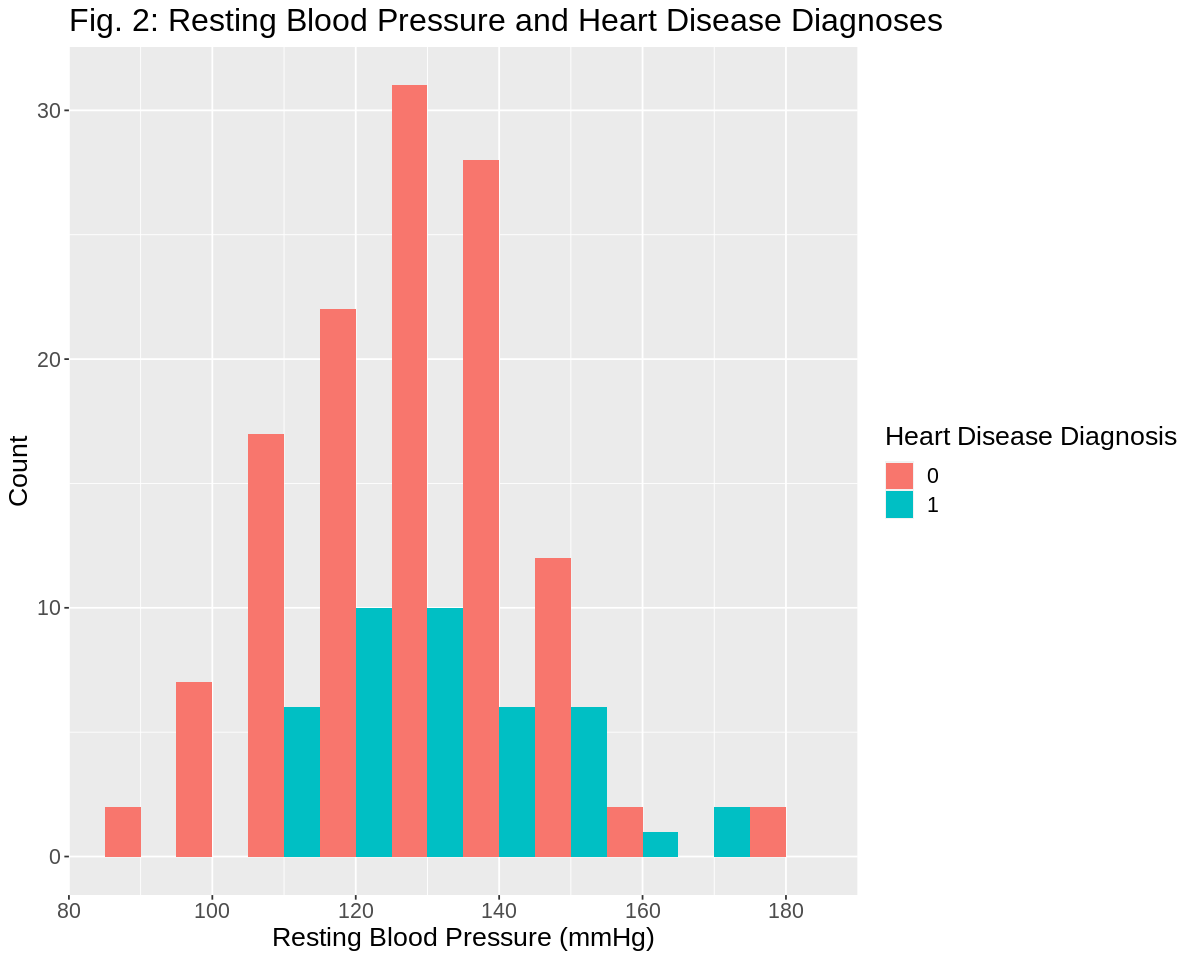

In [10]:
#Making a plot for the resting blood pressure in relation to HD presence. 
#All the titles in the plot and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
resting_bps_plot <- ggplot(resting_train, aes(x = resting_blood_pressure)) +
    ggtitle("Fig. 2: Resting Blood Pressure and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result), position = "dodge", binwidth = 10) +
    xlab("Resting Blood Pressure (mmHg)") +
    ylab("Count") +
    labs(fill = "Heart Disease Diagnosis") +
    theme(text = element_text(size = 16))
resting_bps_plot

<i><b>Figure 2:</b> Resting blood pressure predictor values associated with the HD diagnosis.</i>

Resting blood pressure has a range of ~90-180mmHg, with most data at 110-150mmHg. Diagnoses occur between 110-175mmHg, and with resting blood pressure greater than 150mmHg, the ratio of diagnoses to non-diagnoses decreases.

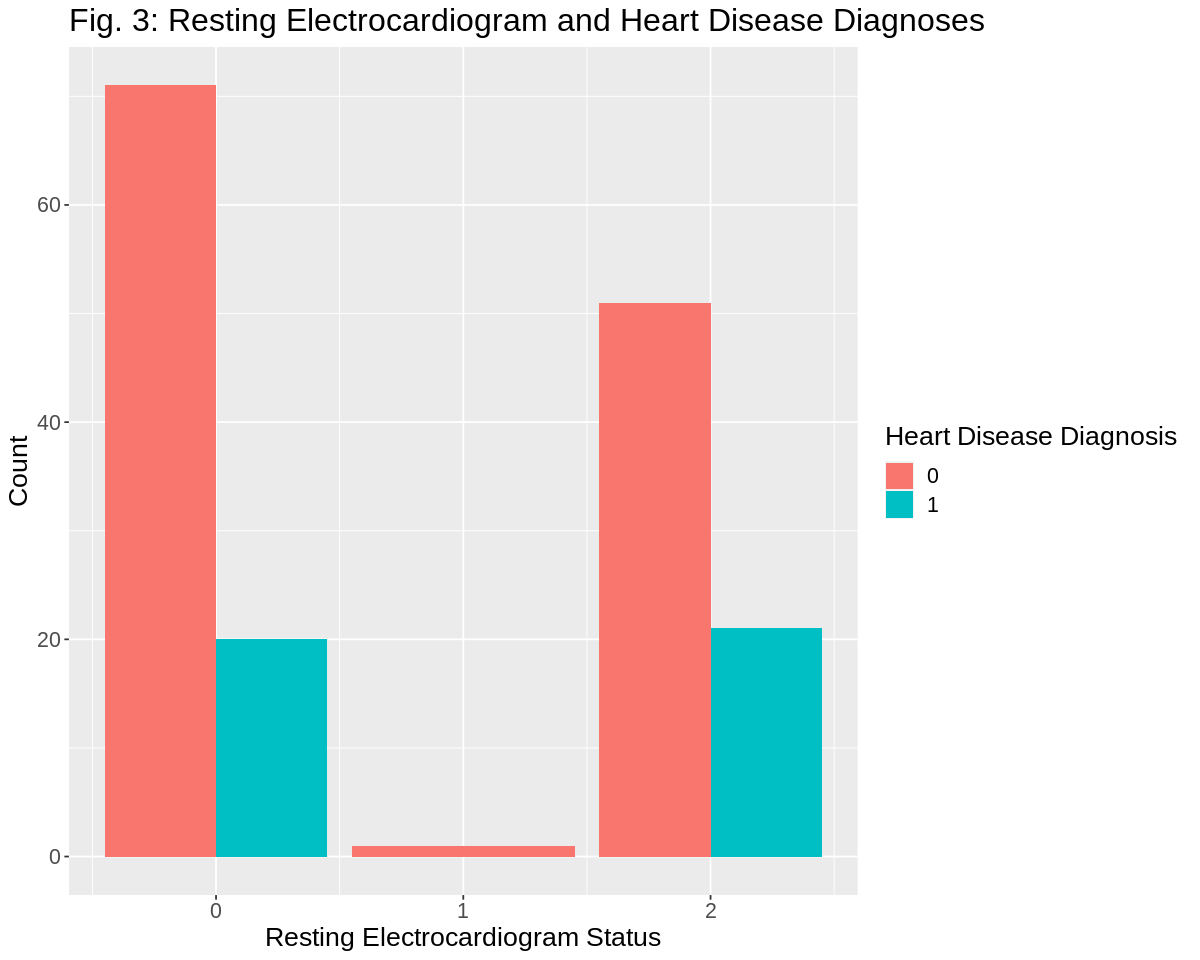

In [35]:
#Plotting the resting electrocardiogram data for each HD diagnosis value. 
#All the titles in the plot and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
resting_electro_plot <- ggplot(resting_train, aes(x = resting_electrocardio)) +
ggtitle("Fig. 3: Resting Electrocardiogram and Heart Disease Diagnoses") +
    geom_bar(aes(fill = result), position = "dodge") +
    xlab("Resting Electrocardiogram Status") +
    ylab("Count") +
    labs(fill = "Heart Disease Diagnosis") +
    theme(text = element_text(size = 16))
resting_electro_plot

<i><b>Figure 3:</b> HD diagnosis as it is related to the resting electrocardiogram results.</i>

Most observations have a resting electrocardiogram status of 0 or 2, with approximately the same number of diagnoses at each. With the 0 value, there are far more non-diagnoses than diagnoses, but this ratio decreases at the resting electrocardiogram of 2, with fewer non-diagnoses.

<b>EXERCISE PREDICTORS GRAPHS:</b>

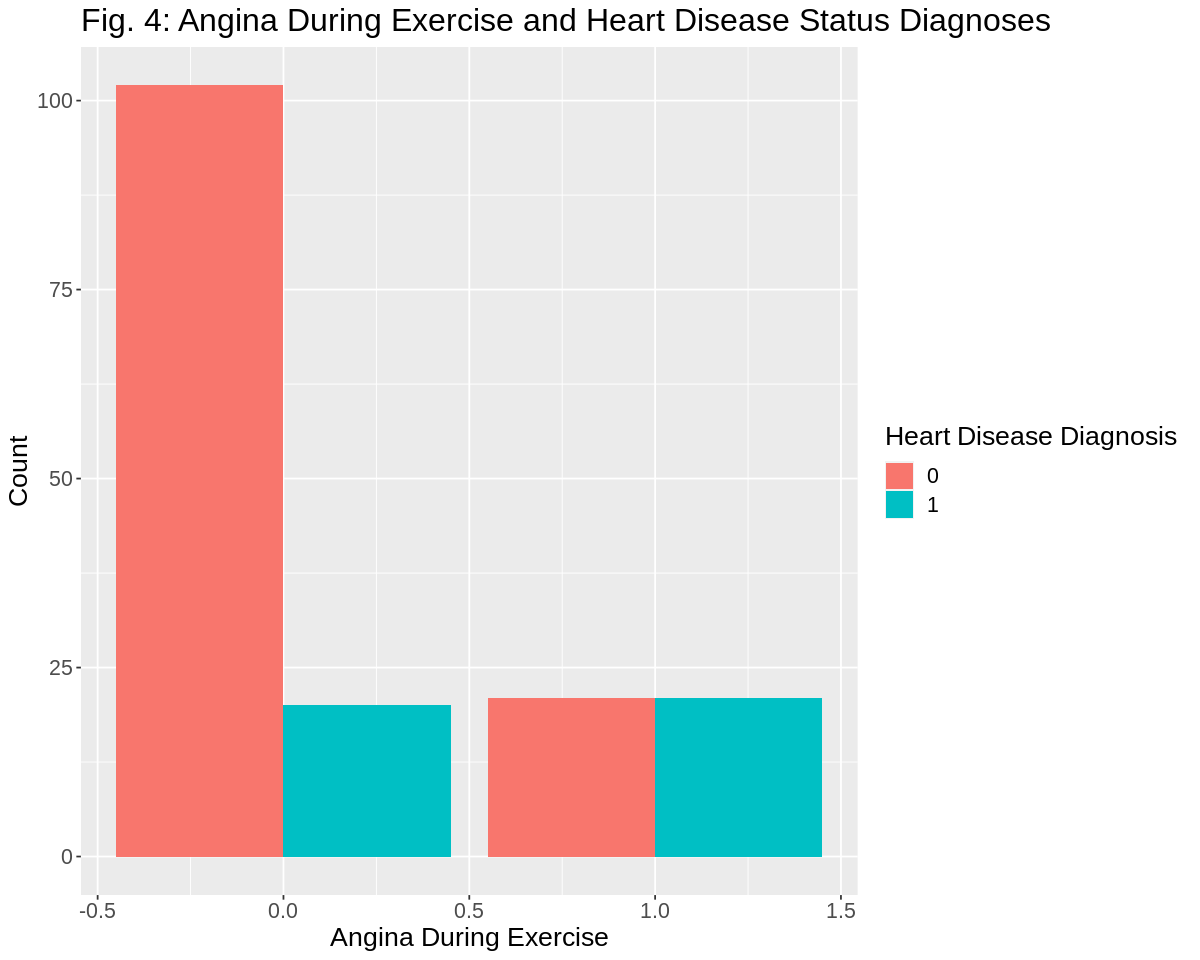

In [47]:
#Visualizing angina during exercise in relation to the HD diagnosis.
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

exercise_angina_plot <- ggplot(exercise_train, aes(x = exercise_angina)) +
ggtitle("Fig. 4: Angina During Exercise and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result), position = "dodge") +
    xlab("Angina During Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Diagnosis") +
    theme(text = element_text(size = 16))
exercise_angina_plot

<i><b>Figure 4:</b> Relationship between angina and HD diagnosis.</i>

Exercise angina is binary, associated with values 0 or 1. At a value of 0, there are more observations with no HD than those with HD. The number of observations with HD is approximately the same with an angina of 0 and 1, however, at an angina of 1, the number of non-diagnoses is the same as the number of diagnoses.

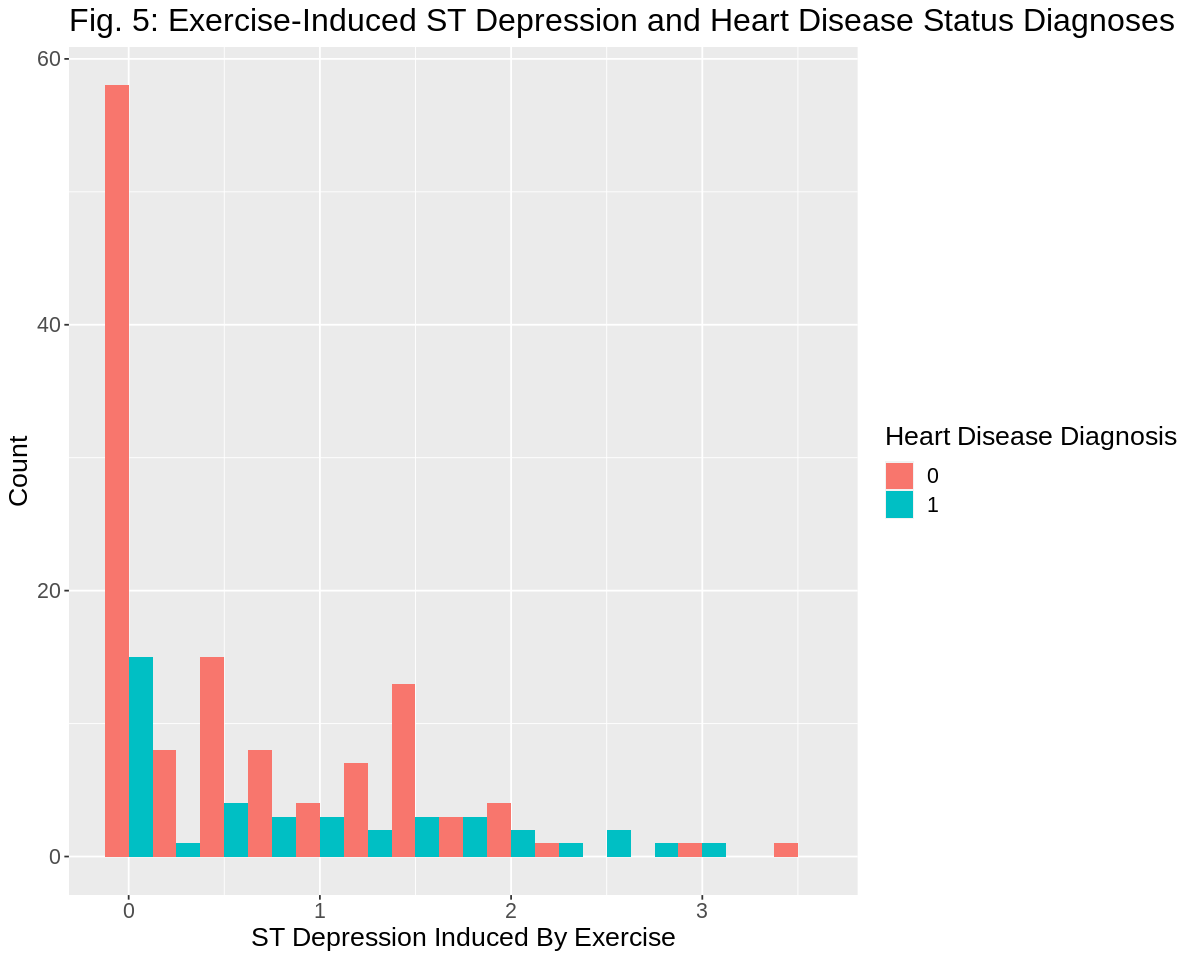

In [13]:
#Visualizing the ST depression during exercise as it relates to HD.
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

exercise_st_plot <- ggplot(exercise_train, aes(x = exercise_st)) +
    ggtitle("Fig. 5: Exercise-Induced ST Depression and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result), position = "dodge", binwidth = 0.25) +
    xlab("ST Depression Induced By Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Diagnosis") +
    theme(text = element_text(size = 16))
exercise_st_plot

<i><b>Figure 5:</b> HD diagnosis as it is related to ST depression during exercise.</i>

ST depression during exercise holds values between 0 and 3.5. At 0, there are a lot more observations with no HD, than with HD, however, as the predictor's value increases, the number of diagnoses compared to non-diagnoses becomes more similar for each value of the predictor.

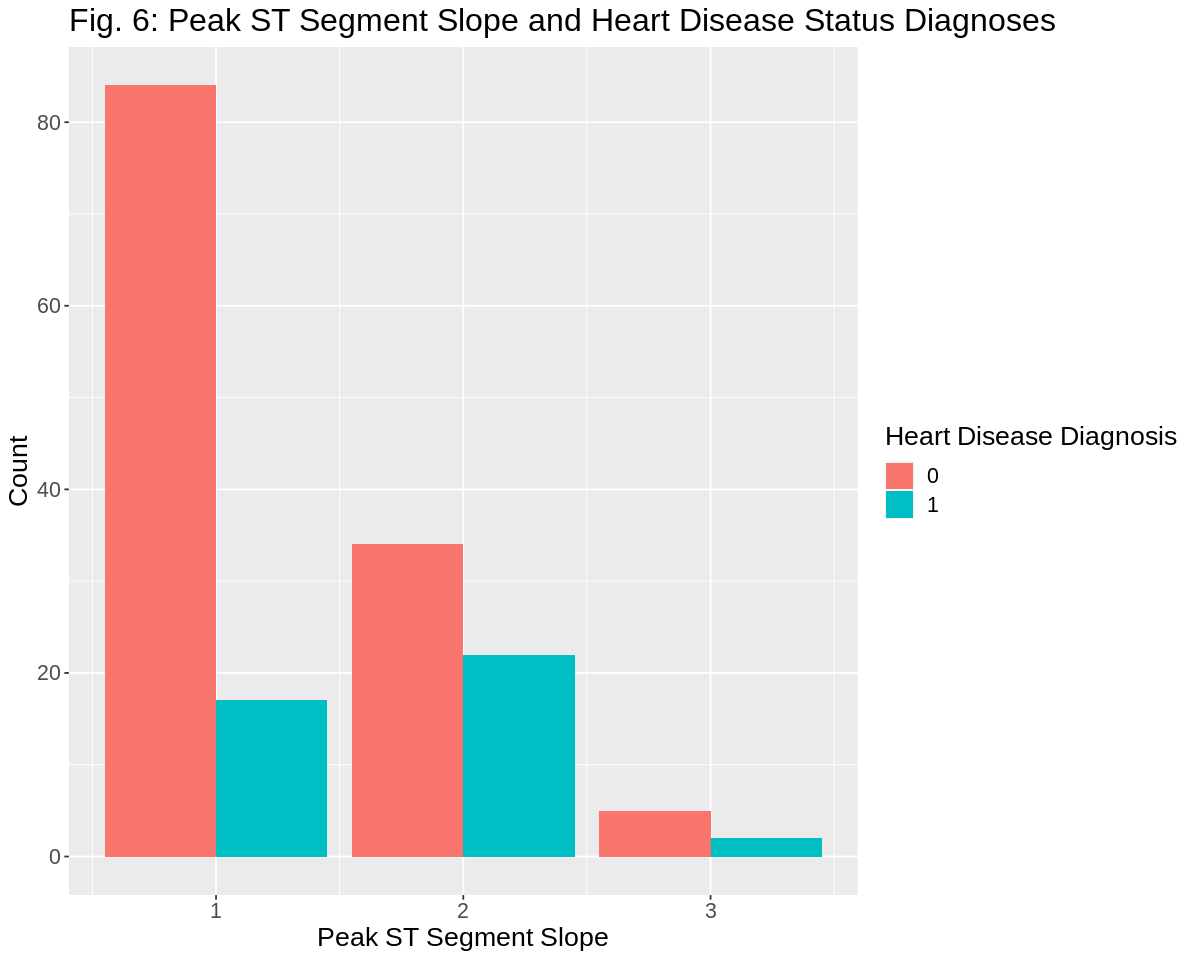

In [39]:
#Graphically visualizing HD diagnosis related to the Peak ST segment slope predictor.
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
exercise_slope_plot <- ggplot(exercise_train, aes(x = exercise_slope)) +
    ggtitle("Fig. 6: Peak ST Segment Slope and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result), position = "dodge") +
    xlab("Peak ST Segment Slope") +
    ylab("Count") +
    labs(fill = "Heart Disease Diagnosis") +
    theme(text = element_text(size = 16))
exercise_slope_plot

<i><b>Figure 6:</b> Segment of the peak ST segment slope and HD diagnosis</i>

This predictor adopts values of 1, 2, or 3. Most observations have values of 1 or 2, and at values of
1, we see far more HD diagnoses than non-diagnoses. However, at values of 2 and 3, the number of non-diagnoses is only slightly higher than the number of diagnoses.

### NON-EXERCISE PREDICTORS MODELING:

Our first model predicts HD using non-exercise predictors.

We need to determine the number of each diagnosis in our training data to determine if the classes are balanced.

In [15]:
# Determining the number of observations of each result to determine if we need to balance the classes.

number_of_each_result_resting <- resting_train |>
    group_by(result) |>
    summarize(count = n())
number_of_each_result_resting

result,count
<fct>,<int>
0,123
1,41


<i><b>Table 3:</b> Number of observations for each result in the non-exercise training set.</i>

The varying number of observations associated with each result shows the classes are not balanced, and we need to do so for modeling.

In [16]:
set.seed(9999)

# Creating a recipe to upsample the data so that we can balance the classes. 
balanced_recipe_resting <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = resting_train) |>
                                step_upsample(result, over_ratio = 1, skip = FALSE) |>
                                prep()

# Baking this recipe with our training data so that the classes are balanced. 
balanced_resting_train <- bake(balanced_recipe_resting, resting_train)

This recipe indicates we are classifying the result variable, using our non-exercise predictors, scaling and centering the data so each predictor equally influences the model. 

In [17]:
# Creating a recipe for the classification using the non-exercise data. 
set.seed(9999)

resting_recipe <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = balanced_resting_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

We specify a classification model, indicating we are tuning the number of neighbours to find an accurate $K$. 


In [18]:
# Creating a model for the classification that we can tune to find the best K. 
set.seed(9999)

resting_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

To tune the model, we perform cross-validation on the training dataset, training the model on a portion, and testing it on the validation set, estimating the $K$ values’ accuracy, specified in the tibble. These are included in the workflow to collect the metrics.

In [19]:
set.seed(9999)

# Creating a cross-validation set. 

resting_vfold <- vfold_cv(resting_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try_resting <- tibble(neighbors = seq(from = 1, to = 20, by = 1))
                   
# Creating a workflow to determine the best K. 

resting_model_workflow <- workflow() |>
                            add_recipe(resting_recipe) |>
                            add_model(resting_model_tune) |>
                            tune_grid(resamples = resting_vfold, grid = k_to_try_resting) |>
                            collect_metrics()

We plot the $K$ values' accuracy to identify the best $K$ for modeling.

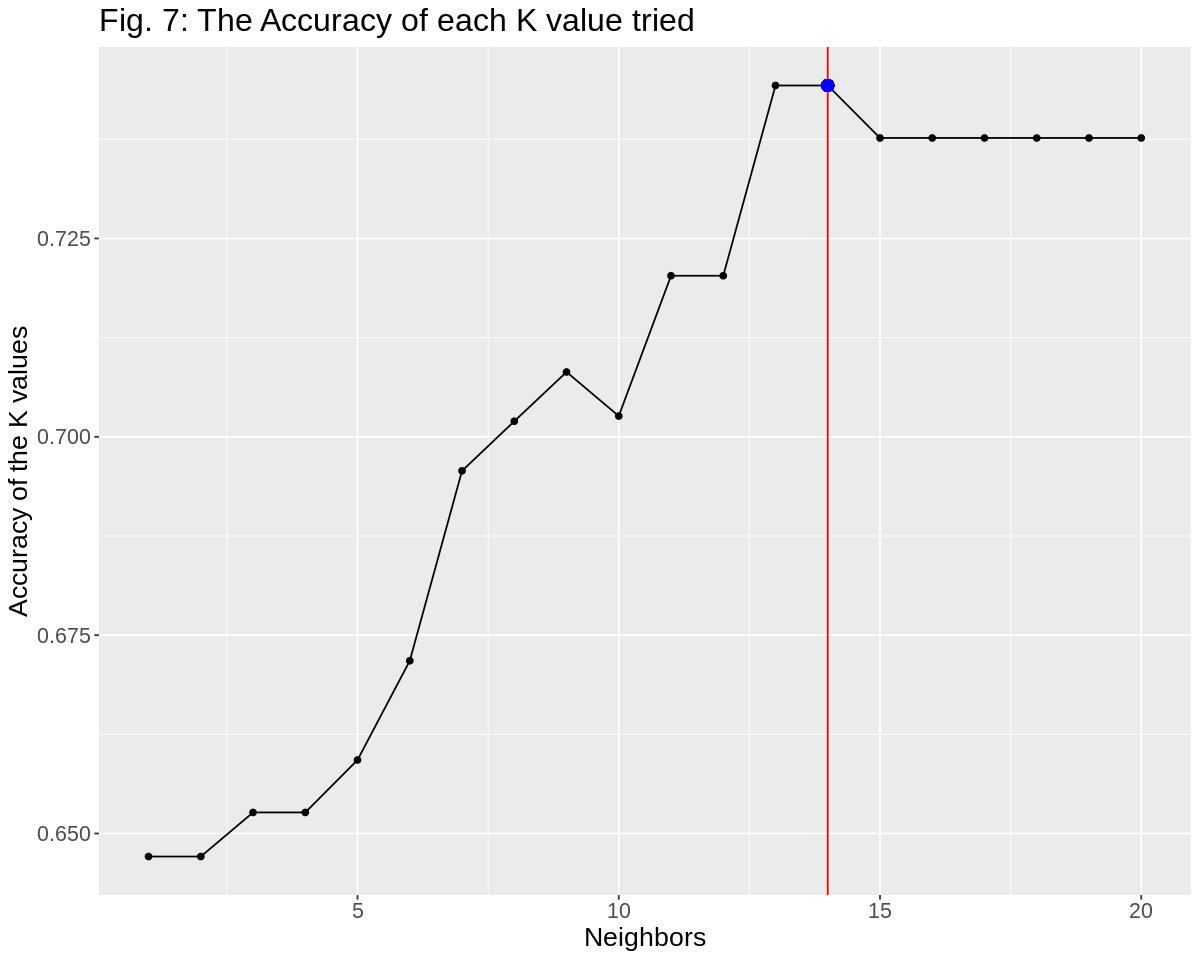

In [20]:
# Filtering the accuracy of each K from the metrics.

accuracy_of_k <- resting_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

highest_accuracy_k <- accuracy_of_k |>
                filter(neighbors == 14) |> 
                select(mean) |>
                pull()

accuracy_plot <- accuracy_of_k |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 14, colour = "red") +
                    geom_point(aes(x = 14, y = highest_accuracy_k), size = 3, colour = "blue") +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("Fig. 7: The Accuracy of each K value tried") +
                    theme(text = element_text(size = 16))

accuracy_plot

<i><b>Figure 7:</b> We choose $K$=14 as it generates the highest accuracy, and its adjacent values are fairly accurate too. 

With the best $K$, we fit a new model to our training data. This trains the model on data it is not tested on so we can achieve a good accuracy estimate.

In [21]:
set.seed(9999)

# Creating a new model which includes the new K to generate the best fit. 

best_resting_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_resting_fit <- workflow() |>
                        add_recipe(resting_recipe) |>
                        add_model(best_resting_model) |>
                        fit(data = balanced_resting_train)

# Using our model on the testing data to make the predictions. 

resting_predictions <- best_resting_fit |>
                        predict(resting_test) |>
                        bind_cols(resting_test)

To analyze the model's accuracy we look at the metrics.  

In [22]:
set.seed(9999)

# Looking at the metrics for this model to determine its accuracy.

resting_metrics <- resting_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy")
resting_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6181818


<i><b>Table 4:</b> Accuracy for the non-exercise predictors model. </i>

Our non-exercise model provides an accuracy of ~0.62, thus correctly diagnoses 62% of the time, yet it performs worse than the majority classifier of ~75%.

We assess the confusion matrix, visualized using ggplot2's autoplot() function to create a heatmap and obtain a comprehensive understanding of the number of correct and incorrect predictions (The R Graph Gallery., 2023).

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



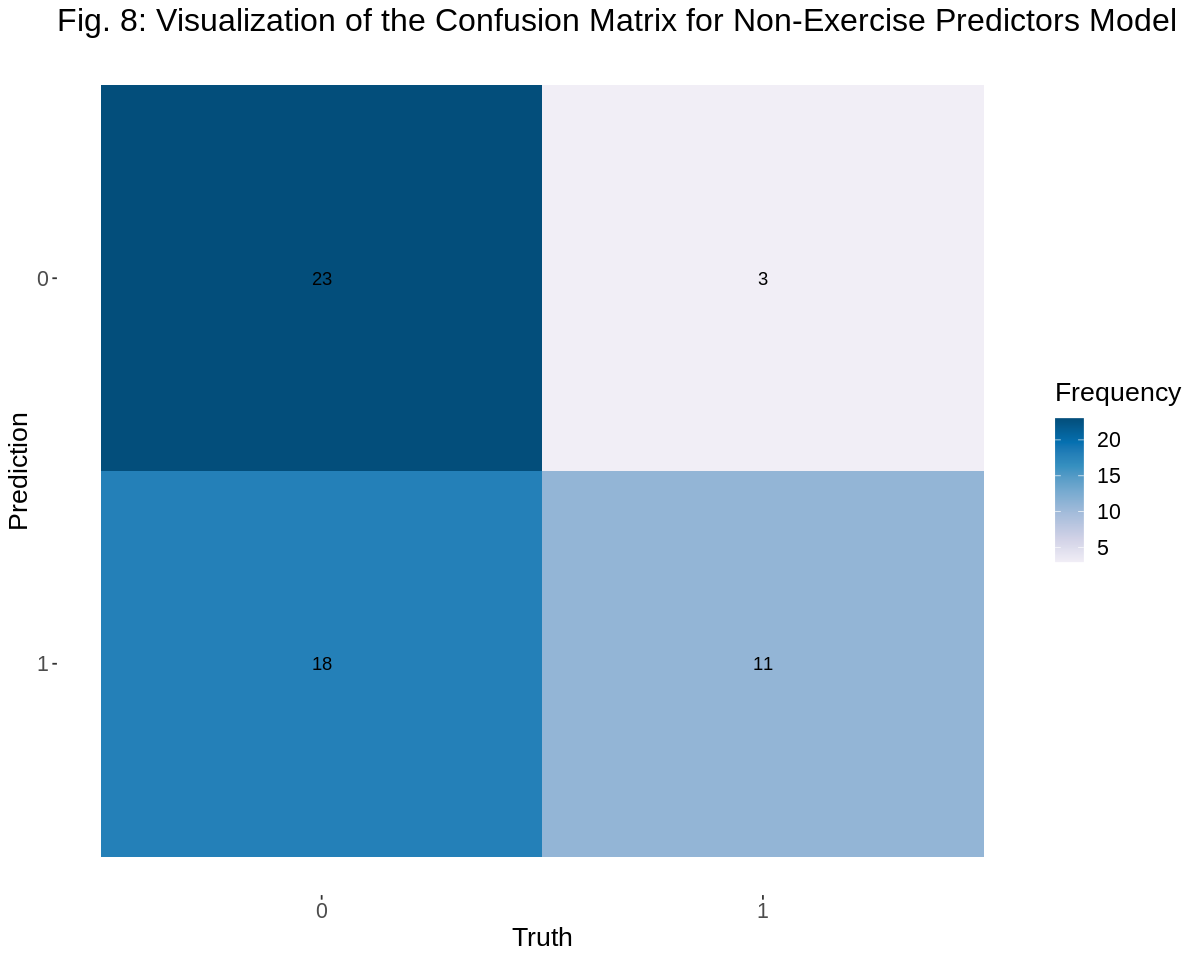

In [23]:
set.seed(9999)

# Visualizing the confusion matrix for the non-exercise predictors model. 
# This code was developed using (The R Graph Gallery, 2023) and (RDocumentation, n.d.) as a guide.
resting_conf_mat <- resting_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)

autoplot(resting_conf_mat, type = "heatmap") +        #  Using ggplot2's autoplot() function as learned in (RDocumentation, n.d.) and (The R Graph Gallery, 2023). 
    scale_fill_distiller(palette = "PuBu", direction = 1, name = "Frequency") +        
    labs(title = "Fig. 8: Visualization of the Confusion Matrix for Non-Exercise Predictors Model") +
    theme(legend.position = "right", text = element_text(size = 16))

<i><b>Figure 8:</b> Plot of the confusion matrix for the non-exercise model. 
   
Our model only made 3 incorrect predictions for HD diagnoses, however, made 18 incorrect predictions for non-diagnoses.

To plot our results, we learned to use the melt function. We initially grouped the results and summarized the accurate and innacurate predictions from the confusion matrix. Using the melt() function we reshaped the dataframe such that we had the count of accurate and innacurate predictions, which could then be plotted. 

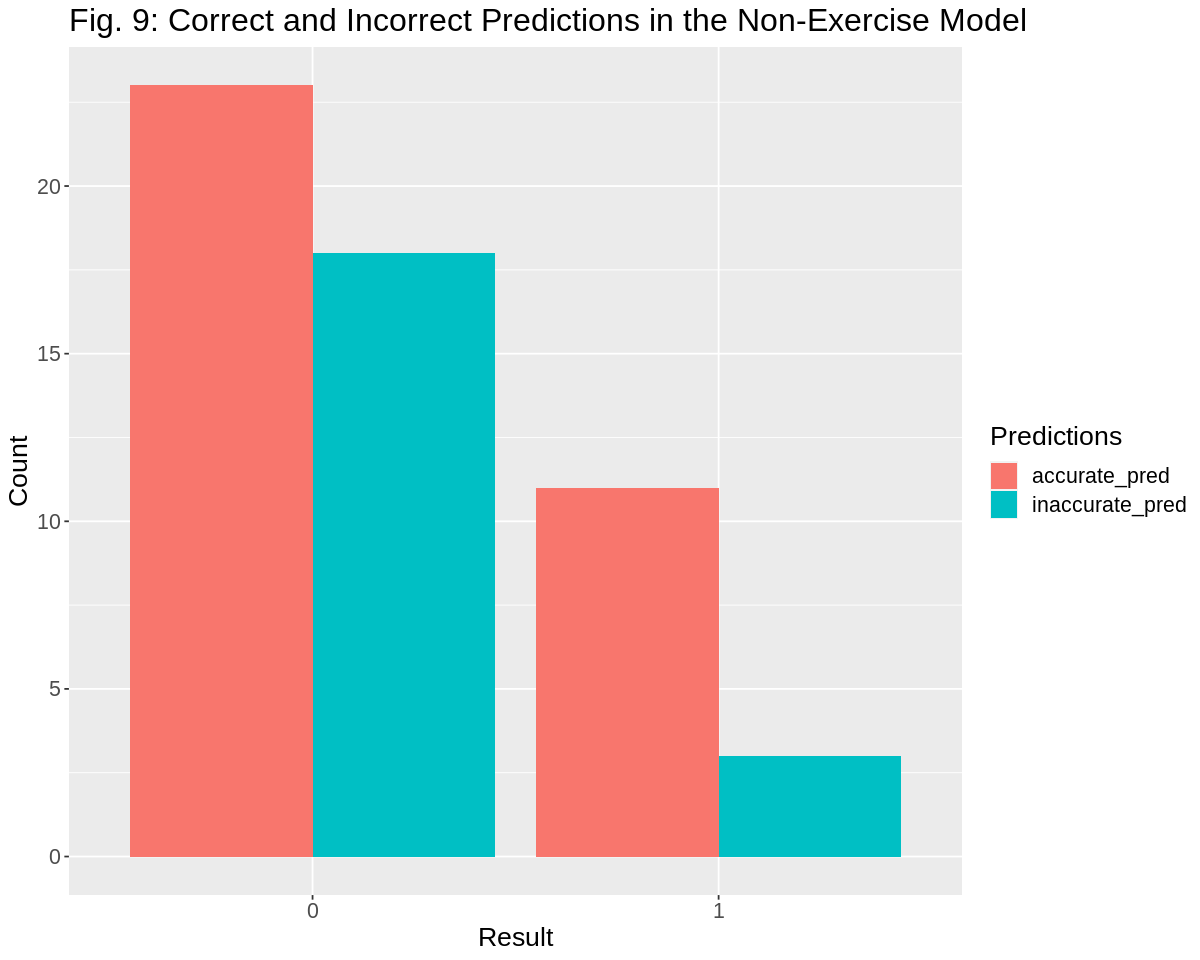

In [24]:
# Making the confusion matrix into a data frame.

resting_pred_accuracy <- resting_predictions |>
    group_by(result)|> 
    summarize(accurate_pred = sum(.pred_class == result), inaccurate_pred = sum(.pred_class != result)) # We learned to use these functions using 
    data_long <- reshape2::melt(resting_pred_accuracy, id.vars = "result")

# Visualizing the confusion matrix as a bar graph. 

resting_pred_accuracy_plot <- ggplot(data_long, aes(x = result, y = value, fill = variable)) +
    ggtitle("Fig. 9: Correct and Incorrect Predictions in the Non-Exercise Model") +
    geom_bar(stat="identity", position = "dodge") +
    labs(x = "Result", y = "Count", fill = "Predictions")+
    theme(text = element_text(size = 16))

resting_pred_accuracy_plot

<i><b>Figure 9:</b> Visualization of the correct and incorrect predictions by the non-exercise model.  
    
For both results, the model makes more accurate predictions than it does inaccurate ones. 

### EXERCISE PREDICTORS MODELING:

The next model uses exercise predictors for HD diagnosis. We must determine whether the classes are balanced before modeling.

In [25]:
# Checking the amount of each of the results in our training set to determine if we have to balance the classes.
number_of_each_result_exercise <- exercise_train |>
    group_by(result) |>
    summarize(count = n())
number_of_each_result_exercise

result,count
<fct>,<int>
0,123
1,41


<i><b>Table 5:</b> Number of observations of each result in the exercise training set.</i>

The number of each result indicates the classes are not balanced, there are more of the 0 result, thus we create a balanced dataset.

In [26]:
set.seed(9999)

# Upsampling the data in a recipe to balance the classes.
balanced_recipe_exercise <- recipe(result ~ exercise_angina + exercise_st + exercise_slope, data = exercise_train) |>
                                step_upsample(result, over_ratio = 1, skip = FALSE) |>
                                prep()

# Using the bake() function with the training data so the classes are balanced. 
balanced_exercise_train <- bake(balanced_recipe_exercise, exercise_train)

This recipe scales and centers the data so all predictors contribute equally to the model. It indicates we are predicting for the result variable. We create a classification model for our analysis to tune the number of neighbours.

In [27]:
# Including the exercise predictors in a recipe for classification. 
set.seed(9999)

exercise_recipe <- recipe(result ~ exercise_angina + exercise_st + exercise_slope, data = exercise_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

In [28]:
# Making a tunable classification model so we can find the best K. 
set.seed(9999)

exercise_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

We perform cross-validation to find the best $K$ by determining each $K$'s accuracy through testing on portions of the training set called validation sets. 

In [29]:
set.seed(9999)

# Creating a cross-validation. 

exercise_vfold <- vfold_cv(exercise_train, v = 10, strata = result)

# Indicating which K values we are going to try. 

k_to_try_exercise <- tibble(neighbors = seq(from = 1, to = 45, by = 1))
                   
# Using these K values in a workflow with the cross-validation to find the best K. 

exercise_model_workflow <- workflow() |>
                            add_recipe(exercise_recipe) |>
                            add_model(exercise_model_tune) |>
                            tune_grid(resamples = exercise_vfold, grid = k_to_try_exercise) |>
                            collect_metrics()

We determine the best $K$, by plotting the $K$ tried with respect to their accuracy.

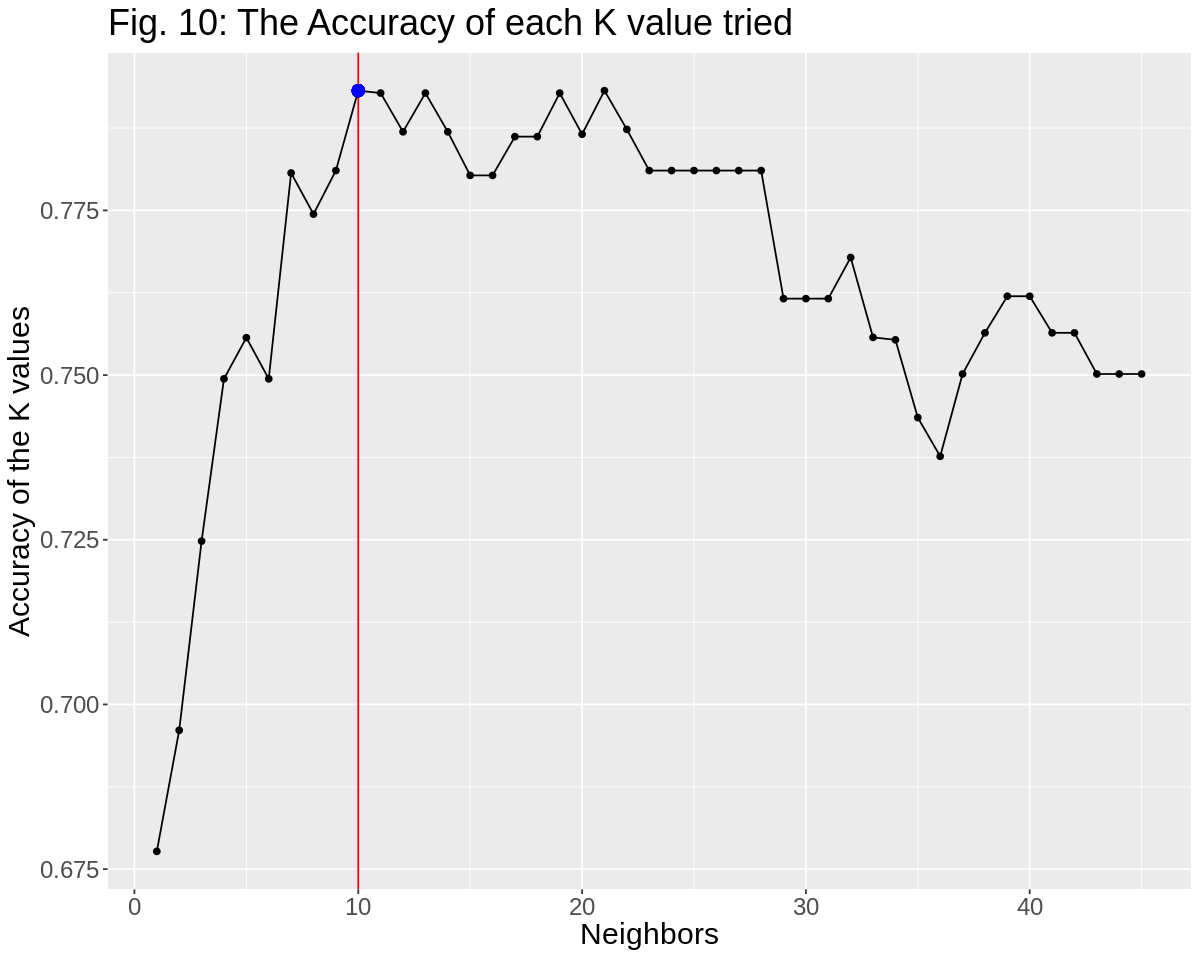

In [30]:
accuracy_of_k_exercise <- exercise_model_workflow |>
                    filter(.metric == "accuracy")

# Plotting the accuracy of each K value to find the best one to use in our classification analysis.

highest_accuracy <- accuracy_of_k_exercise |>
                filter(neighbors == 10) |> 
                select(mean) |>
                pull()

accuracy_plot_exercise <- accuracy_of_k_exercise |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 10, colour = "red") +
                    geom_point(aes(x = 10, y = highest_accuracy), size = 3, colour = "blue") +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("Fig. 10: The Accuracy of each K value tried") +
                    theme(text = element_text(size = 18))
accuracy_plot_exercise

<i><b>Figure 10:</b> We are using $K$=10 as its accuracy is highest with its adjacent values being accurate too. 

Thus, we use this $K$ in a model fit to our training data, to predict the testing data's results.

In [31]:
set.seed(9999)

# Generating a model with the K we determined to be the most accurate. 

best_exercise_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Fitting the model to the training data to train it in a workflow. 

best_exercise_fit <- workflow() |>
                        add_recipe(exercise_recipe) |>
                        add_model(best_exercise_model) |>
                        fit(data = balanced_exercise_train)

# Making predictions on the testing data by fitting our model to it. 

exercise_predictions <- best_exercise_fit |>
                        predict(exercise_test) |>
                        bind_cols(exercise_test)

Through analyzing the metrics and confusion matrix we can determine this model's success at predicting the testing data's classes.

In [32]:
set.seed(9999)

# Determining the model's accuracy by assessing the metrics. 

exercise_metrics <- exercise_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy")
exercise_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7636364


<i><b>Table 6:</b> Accuracy of the exercise predictor's model. </i>

This model has an accuracy of ~0.76, thus 76% of its predictions are correct, which is approximately equivalent to the majority classifier's accuracy of 75%.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



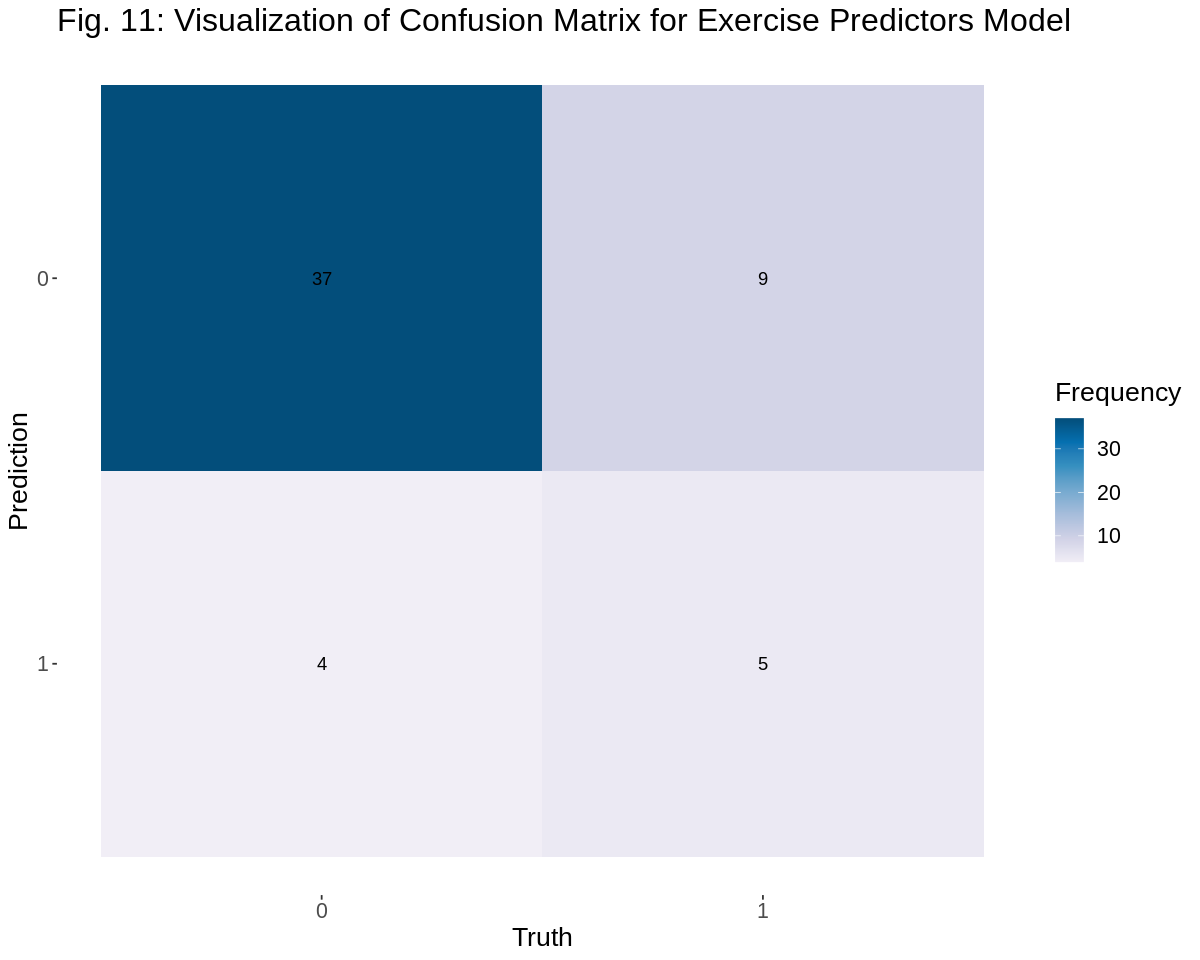

In [33]:
set.seed(9999)

# Visualizing the confusion matrix for the exercise predictors model to better assess its accuracy.
# This code was developed using (The R Graph Gallery, 2023) and (RDocumentation, n.d.) as a guide.

exercise_conf_mat <- exercise_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)

autoplot(exercise_conf_mat, type = "heatmap") +  #  Using ggplot2's autoplot() function as learned in (RDocumentation, n.d.) and (The R Graph Gallery, 2023). 
    scale_fill_distiller(palette = "PuBu", direction = 1, name = "Frequency") +       
    labs(title = "Fig. 11: Visualization of Confusion Matrix for Exercise Predictors Model") +
    theme(legend.position = "right", text = element_text(size = 16))

<i><b>Figure 11:</b> Confusion matrix visualization for the non-exercise model.

This model makes only four incorrect predictions when there is no HD and nine when HD is present.

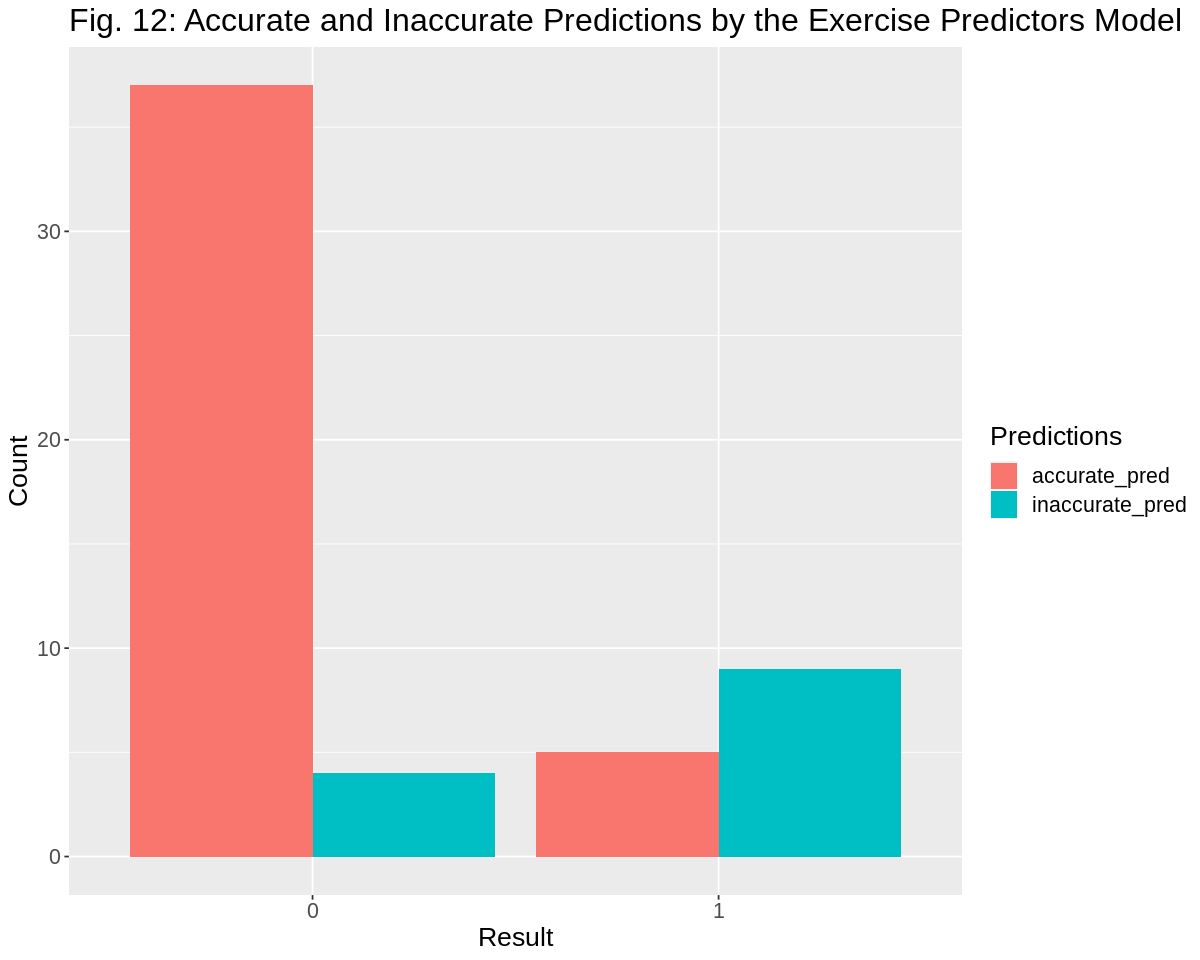

In [34]:
# Making a data frame from the confusion matrix data.
exercise_pred_accuracy <- exercise_predictions |>
    group_by(result)|> 
    summarize(accurate_pred = sum(.pred_class == result), inaccurate_pred = sum(.pred_class != result)) # We learned to use these functions using
    data_long <- reshape2::melt(exercise_pred_accuracy, id.vars = "result")

# Visualizing the confusion matrix as a bar graph. 
exercise_pred_accuracy_plot <- ggplot(data_long, aes(x = result, y = value, fill = variable)) +
    ggtitle("Fig. 12: Accurate and Inaccurate Predictions by the Exercise Predictors Model") +
    geom_bar(stat="identity", position = "dodge") +
    labs(x = "Result", y = "Count", fill = "Predictions")+
    theme(text = element_text(size = 16))

exercise_pred_accuracy_plot

<i><b>Figure 12:</b> Graphical visualization of the correct and incorrect predictions by the exercise model.

This model predicts no HD more accurately than it does inaccurately, however, it makes more incorrect predictions for the presence of HD than correct ones.

### Discussion


<b>Summary:</b>
Exercise-related indicators of HD yielded higher accuracy than non-exercise predictors. The exercise predictor accuracy was ~76% (Table 6), while that of the non-exercise predictors was ~62% (Table 4). According to our confusion matrices, the non-exercise model (Figures 8 and 9) would predict both results correctly more than incorrectly. It makes more false negative than false positive predictions. The exercise model (Figures 11 and 12) correctly predicted no HD more than incorrectly. However, when HD is present it makes more incorrect predictions than correct ones. Thus, when compared to non-exercise indicators, exercise-related indicators are less likely to diagnose a healthy patient with HD, but increasingly diagnose HD patients as healthy.


<b>Expected outcomes:</b>
We were not expecting either model to be perfectly accurate as they both only employ a subset of predictors. However, we hoped for higher accuracies than those achieved as the predictors in each model were relevant in HD diagnosis, as explained in our preliminary analysis. Our non-exercise model performs worse than the majority classifier of 0, which accounts for ~75% of the observations, while our exercise model is comparable. This was expected as, clinically, HD diagnoses involve (Olsen et al., 2020) studying "patient's history, their physical examination, and both laboratory and imaging data" (Olsen et al., 2020) which are not all reflected in our models, thus identifying a reason for the low accuracy. 


We expected our exercise model to be more accurate for HD diagnosis than our resting model, as it considers parameters involved in exercise testing. Exercise testing is more sensitive in HD diagnosis and can be implemented in individuals with a range of symptoms (Sahni et al., 2011). While the results of these tests alone are insufficient for HD diagnosis, clinically, they are coupled with other HD determinants including age (Harvard Health Publishing, 2020), thus explaining our exercise model's higher accuracy than the non-exercise model.


<b>Impact:</b>
Clinically, rapid HD diagnosis in its early stages is vital (Garavand et al., 2022). These models would not be suitable for these early diagnoses as they predict many false negatives, particularly the non-exercise model. By waiting longer for diagnosis, patient mortality increases (Garavand et al., 2022). Thus, the impact is that we determine that HD diagnosis relative to these predictors is insufficient to make a timely diagnosis.  

These models are impactful to devise HD diagnostic paradigms. While there is an association between these predictors and HD, they are not sufficient alone for diagnosis according to our models' accuracy. In practice, “cardiovascular disease is difficult to recognize due to a variety of risk factors” (Nadakinamani et al., 2022). Thus, this, combined with our models, is impactful in suggesting there is more to consider than exercise and non-exercise predictors for HD diagnosis. 

<b>Future Directions:</b>
Looking forward, our analysis shows that exercise predictors can increase HD diagnostic accuracy; however, this decreases testing accessibility, as exercise testing is not applicable to all patients, as some are physically incapacitated, or require more detailed testing (Harvard Health Publishing, 2010). Currently, our model boasts a 76% accuracy, raising the question of whether this is sufficient to justify the accessibility tradeoffs. Another question explores how we can devise a more accurate model for HD prediction, as looking at non-exercise and exercise predictors alone is insufficient. Based on our analysis, further research into more HD-related factors and combinations of factors from different classes could be done to construct an optimized diagnostic model.

<b>Word Count:</b> 1966 words

<b>References:</b>

Bösner, S., Becker, A., Hani, M.A., Keller, H., Sönnichsen, A.C., Haasenritter, J., Karatolios, K., Schaefer, J.R., Baum, E., and Donner-Banzhoff, N. (2010). Accuracy of Symptoms and Signs for Coronary Heart Disease Assessed in Primary Care. <i>British Journal of General Practice, 60</i>(575), 246-257. 10.3399/bjgp10X502137

DataScience Made Simple. (2023). <i>Case when in R using case_when() dplyr - case_when in R</i>. DataScience Made Simple. https://www.datasciencemadesimple.com/case-statement-r-using-case_when-dplyr/ 

Detrano, R. (n.d.). <i>processed.cleveland.data</i> [Data set]. UCI Machine Learning 
Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Finkelhor, R.S., Newhouse, K.E., Vrobel, T.R., Miron, S.D., and Bahler, R.C. (1986). The ST Segment/Heart Rate Slope as a Predictor of Coronary Artery Disease: Comparison with Quantitative Thallium Imaging and Conventional ST Segment Criteria. <i>American Heart Journal. 112</i>(2), 296-304. https://doi.org/10.1016/0002-8703(86)90265-6

Garavand, A., Salehnasab, C., Behmanesh, A., Aslani, N., Zadeh, A.H., and Ghaderzadeh, M. (2022). Efficient Model for Coronary Artery Disease Diagnosis: A Comparative Study of Several Machine Learning Algorithms. <i>Journal of Healthcare Engineering, 2022</i>. https://doi.org/10.1155/2022/5359540

Harvard Health Publishing. (2021, September 21). <i>Angina: Symptoms, diagnosis and treatments</i>. Harvard Medical School. https://www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-and-treatments

Harvard Health Publishing. (2020, April 15). <i>Cardiac exercise stress testing: What it can and cannot tell you</i>. Harvard Medical School. https://www.health.harvard.edu/heart-disease/cardiac-exercise-stress-testing-what-it-can-and-cannot-tell-you.

Harvard Health Publishing. (2010, April 1). <i>Exercise stress test<i>. Harvard Medical School. https://www.health.harvard.edu/heart-health/exercise-stress-test

Lanza, G.A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G.A., and Crea, F. (2004). 
Diagnostic and Prognostic Value of ST Segment Depression Limited to the Recovery Phase of Exercise Stress Test. <i>Heart. 90</i>(12), 1417-1421. 10.1136/hrt.2003.031260

Nadakinamani, R.G., Reyana, A., Kautish, S., Vibith, A.S., Gupta, Y., Abdelwahab, S.F., and Mohamed, A.W. (2022). Clinical Data Analysis for Prediction of Cardiovascular Disease Using Machine Learning Techniques. <i>Computation Intelligence and Neuroscience, 2022</i>. 10.1155/2022/2973324

Olsen, C.R., Mentz, R.J, Anstrom, K.J., Page, D., and Patel, P.A. (2020). Clinical Applications of Machine Learning in the Diagnosis, Classification, and Prediction of Heart Failure. <i>American Heart Journal, 229</i>, 1-17. https://doi.org/10.1016/j.ahj.2020.07.009

RDocumentation (n.d.). <i>Autoplot: Generic autoplot function</i>. RDocumentation. https://www.rdocumentation.org/packages/ggbio/versions/1.20.1/topics/autoplot


Sahni, S, Vaishnava, P., and Darrow, B. (2011). Coronary Heart Disease in the Elderly: Identifying Established and Subclinical Disease with Stress Testing. <i>Mount Sinai Journal of Medicine, 78</i>(4). doi:10.1002/msj.20273

Shin, J., Ham, D., Shin, S., Choi, S.K., Paik, H-Y., and Joung, H. (2019). Effects of 
Lifestyle-Related Factors on Ischemic Heart Disease According to Body Mass Index and Fasting Blood Glucose Levels in Korean Adults. <i>PLoS ONE, 14</i>(5). https://doi.org/10.1371/journal.pone.0216534

The R Graph Gallery. (2023). Heatmap. The R Graph Gallery. https://r-graph-gallery.com/heatmap.html.

Wu, C-Y., Hu, H-Y., Chou, Y-J., Huang, N., Chou, Y-C., Li, C-P. (2015). High Blood Pressure 
and All-Cause and Cardiovascular Disease Mortalities in Community-Dwelling Older Adults. </i>Medicine (Baltimore). 94</i>(47). 10.1097/MD.0000000000002160
